In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/data/accidents.csv'

In [ ]:
!pip install pyspark

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [ ]:
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Project") \
    .config("spark.sql.shuffle.partitions", "400") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.cores", "8") \
    .config("spark.driver.cores", "8") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "4") \
    .config("spark.dynamicAllocation.maxExecutors", "16") \
    .config("spark.dynamicAllocation.initialExecutors", "16") \
    .getOrCreate()


In [ ]:
df = spark.read.csv(file_path, inferSchema=True, header=True)

In [ ]:
total_rows = df.count()
print(f"Toplam satır sayısı: {total_rows}")

fraction = 4000000 / total_rows
df = df.sample(withReplacement=False, fraction=fraction, seed=42)

Toplam satır sayısı: 7728394


In [ ]:
df.cache()

DataFrame[ID: string, Source: string, Severity: int, Start_Time: string, End_Time: string, Start_Lat: double, Start_Lng: double, End_Lat: double, End_Lng: double, Distance(mi): double, Description: string, Street: string, City: string, County: string, State: string, Zipcode: string, Country: string, Timezone: string, Airport_Code: string, Weather_Timestamp: string, Temperature(F): double, Wind_Chill(F): double, Humidity(%): double, Pressure(in): double, Visibility(mi): double, Wind_Direction: string, Wind_Speed(mph): double, Precipitation(in): double, Weather_Condition: string, Amenity: boolean, Bump: boolean, Crossing: boolean, Give_Way: boolean, Junction: boolean, No_Exit: boolean, Railway: boolean, Roundabout: boolean, Station: boolean, Stop: boolean, Traffic_Calming: boolean, Traffic_Signal: boolean, Turning_Loop: boolean, Sunrise_Sunset: string, Civil_Twilight: string, Nautical_Twilight: string, Astronomical_Twilight: string]

In [ ]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility

In [ ]:
df_pd = df.toPandas()

<ipython-input-12-44beed33e019>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(x='State', data=df_pd, orient = 'v', palette = 'crest_r', order = df_pd['State'].value_counts().index)


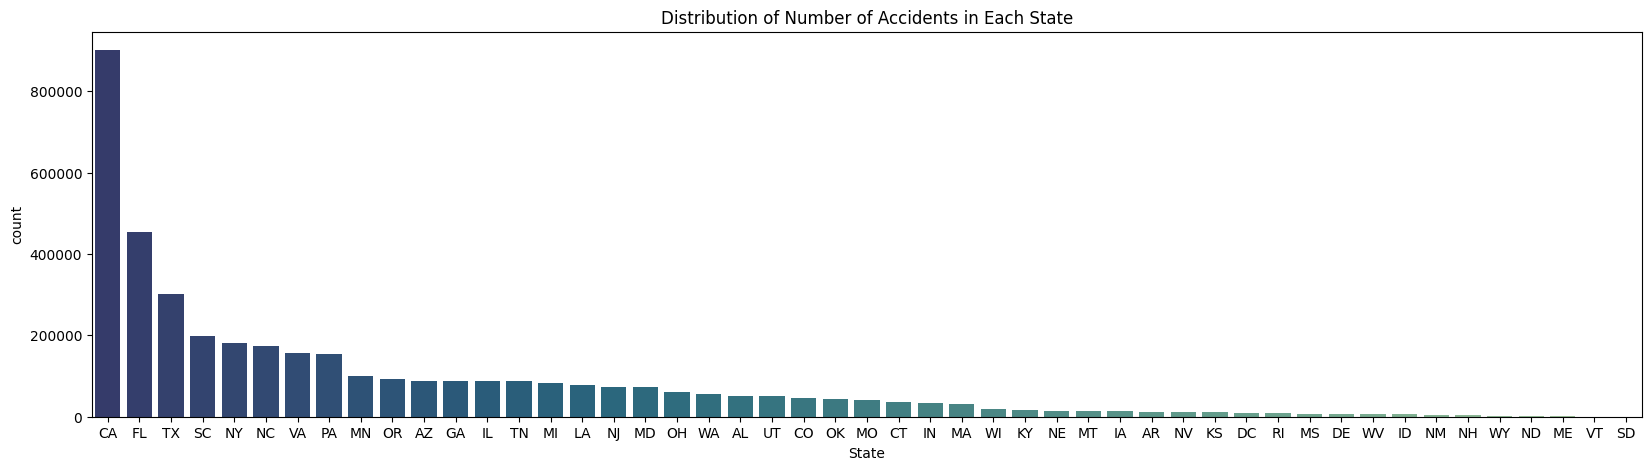

In [ ]:
fig, ax = plt.subplots(figsize = (20,5))
plot = sns.countplot(x='State', data=df_pd, orient = 'v', palette = 'crest_r', order = df_pd['State'].value_counts().index)
plot.set_title('Distribution of Number of Accidents in Each State')
plt.show();

<ipython-input-13-d91b88381db2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(x='City', data = df_pd, order=df_pd.City.value_counts().iloc[:50].index, orient = 'v', palette = 'crest_r')
<ipython-input-13-d91b88381db2>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


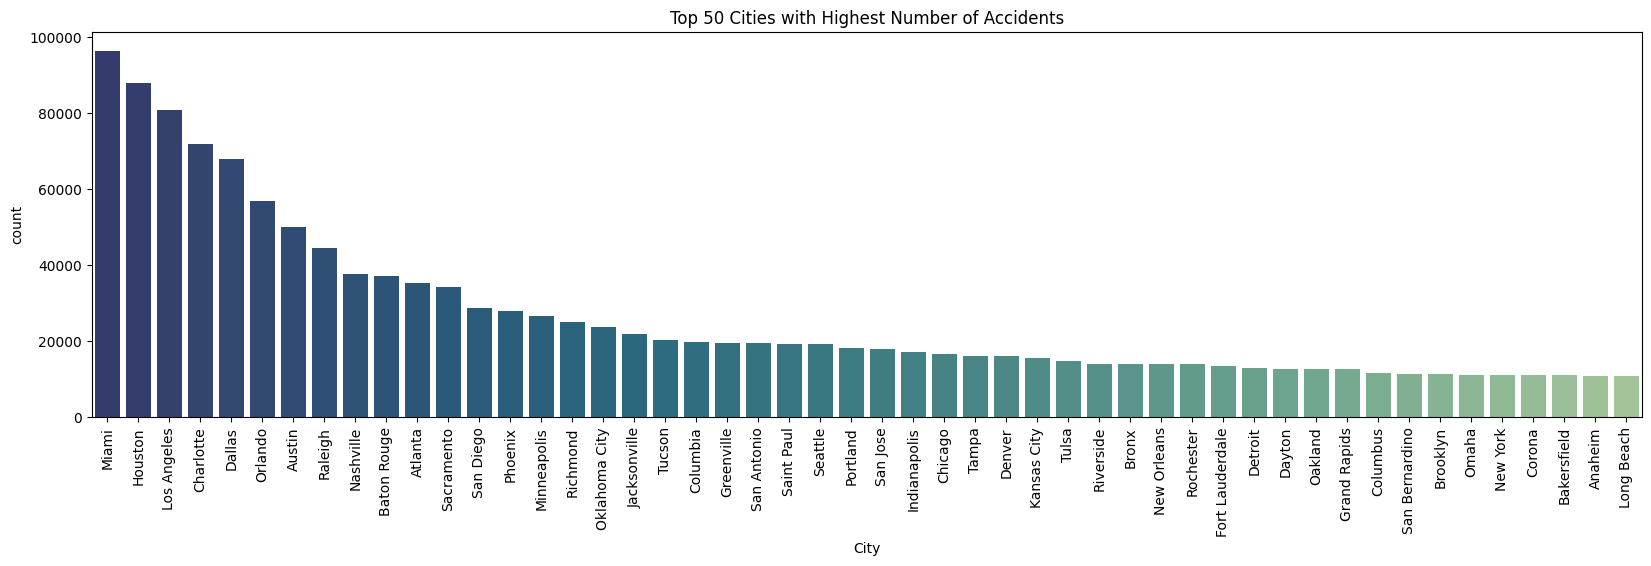

In [ ]:
fig, ax = plt.subplots(figsize = (20,5))
plot = sns.countplot(x='City', data = df_pd, order=df_pd.City.value_counts().iloc[:50].index, orient = 'v', palette = 'crest_r')
plot.set_title('Top 50 Cities with Highest Number of Accidents')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.show();

<Axes: ylabel='count'>

Text(0.5, 1.0, 'Percentage Severity Distribution')

Text(0, 0.5, 'Count')

<Axes: xlabel='Severity', ylabel='count'>

Text(0.5, 1.0, 'Count of Severity')

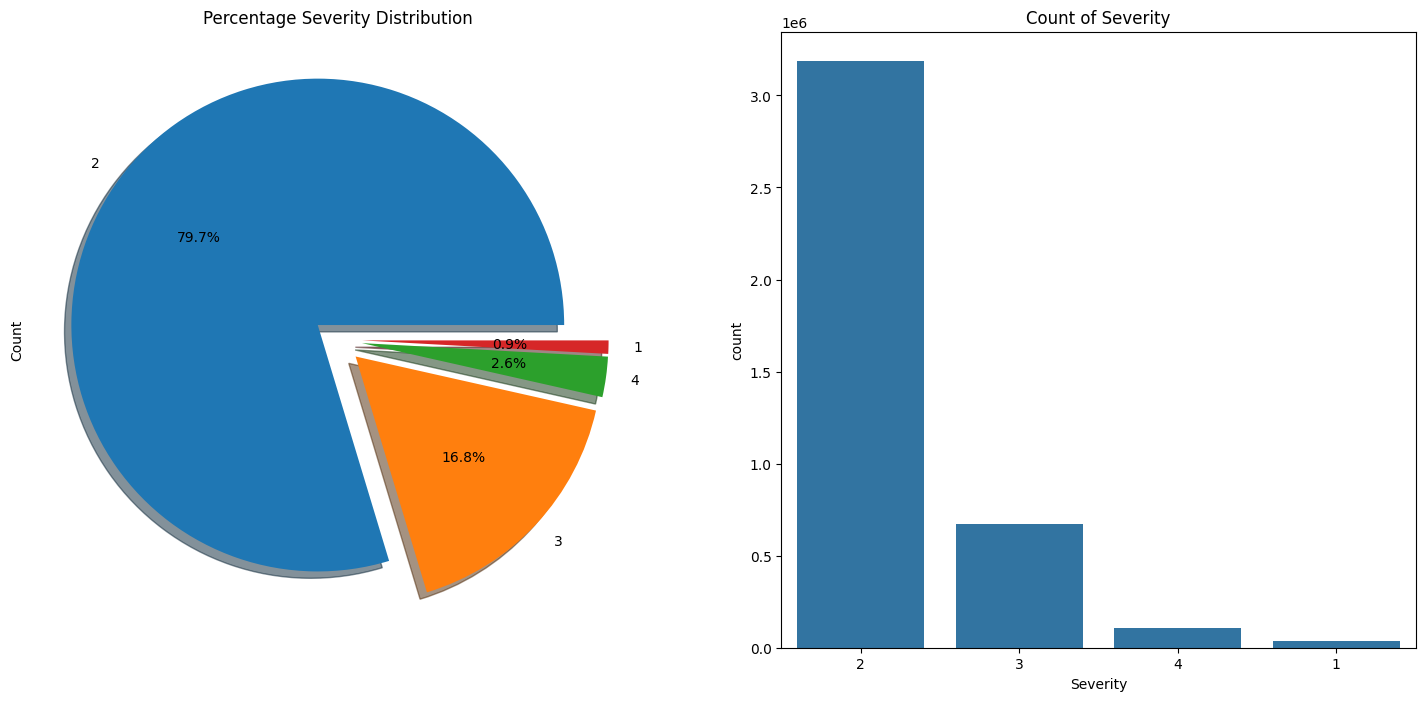

In [ ]:
unique_severity_count = df_pd['Severity'].nunique()
unique_severity_count = df_pd['Severity'].nunique()
explode = [0.1] * unique_severity_count
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_pd['Severity'].value_counts().plot.pie(explode=explode, autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Percentage Severity Distribution')
ax[0].set_ylabel('Count')

sns.countplot(x='Severity', data=df_pd, ax=ax[1], order=df_pd['Severity'].value_counts().index)
ax[1].set_title('Count of Severity')

plt.show()

In [ ]:
!pip install folium

In [ ]:
import folium
from folium.plugins import MarkerCluster

In [ ]:
df_map = df_pd.loc[:2000,:]
df_map.shape
df_loc = df_map[['Start_Lat' , 'Start_Lng']]

(2001, 46)

In [ ]:
def create_map(df_loc, latitude, longitude, zoom, tiles='OpenStreetMap'):
    world_map = folium.Map(location=[latitude, longitude], zoom_start=zoom, tiles=tiles)
    marker_cluster = MarkerCluster().add_to(world_map)

    for idx, row in df_loc.iterrows():
        folium.Marker(
            location=[row['Start_Lat'], row['Start_Lng']],
            popup=f"Lat, Lng: {row['Start_Lat']}, {row['Start_Lng']}"
        ).add_to(marker_cluster)

    return world_map

In [ ]:
us_cities_coords = {
    "New York": {"lat": 40.7128, "lon": -74.0060},
    "Los Angeles": {"lat": 34.0522, "lon": -118.2437},
    "Chicago": {"lat": 41.8781, "lon": -87.6298},
    "Houston": {"lat": 29.7604, "lon": -95.3698},
    "Phoenix": {"lat": 33.4484, "lon": -112.0740},
    "Philadelphia": {"lat": 39.9526, "lon": -75.1652},
    "San Antonio": {"lat": 29.4241, "lon": -98.4936},
    "San Diego": {"lat": 32.7157, "lon": -117.1611},
    "Dallas": {"lat": 32.7767, "lon": -96.7970},
    "San Jose": {"lat": 37.3382, "lon": -121.8863},
    "Austin": {"lat": 30.2672, "lon": -97.7431},
    "Jacksonville": {"lat": 30.3322, "lon": -81.6557},
    "Fort Worth": {"lat": 32.7555, "lon": -97.3308},
    "Columbus": {"lat": 39.9612, "lon": -82.9988},
    "San Francisco": {"lat": 37.7749, "lon": -122.4194},
    "Charlotte": {"lat": 35.2271, "lon": -80.8431},
    "Indianapolis": {"lat": 39.7684, "lon": -86.1581},
    "Seattle": {"lat": 47.6062, "lon": -122.3321},
    "Denver": {"lat": 39.7392, "lon": -104.9903},
    "Washington": {"lat": 38.9072, "lon": -77.0369}
}

In [ ]:
map_us = create_map(df_loc, 39.50, -98.35, 4)
map_us

In [ ]:
map_ny = create_map(
    df_loc, us_cities_coords['New York']['lat'],
    us_cities_coords['New York']['lon'],
    10, tiles="cartodbpositron")
map_ny

In [ ]:
def create_accident_map(df_loc):
    """Generate a map with CircleMarkers for accident locations."""
    m = folium.Map(location=[39.8283, -98.5795], width="100%", height="100%", zoom_start=4)

    for index, row in df_loc.iterrows():
        lat = row['Start_Lat']
        lon = row['Start_Lng']

        if not pd.isnull(lat) and not pd.isnull(lon):
            folium.CircleMarker(
                location=[lat, lon],
                radius=1,
                color='blue',
                fill=True,
                fill_color='red',
                fill_opacity=0.6
            ).add_to(m)

    return m

create_accident_map(df_loc)

In [ ]:
df_pd['Start_Time'] = pd.to_datetime(df_pd['Start_Time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

df_pd['Month'] = df_pd['Start_Time'].dt.month
df_pd['Year'] = df_pd['Start_Time'].dt.year
df_pd['Hour'] = df_pd['Start_Time'].dt.hour
df_pd['Weekday'] = df_pd['Start_Time'].dt.weekday

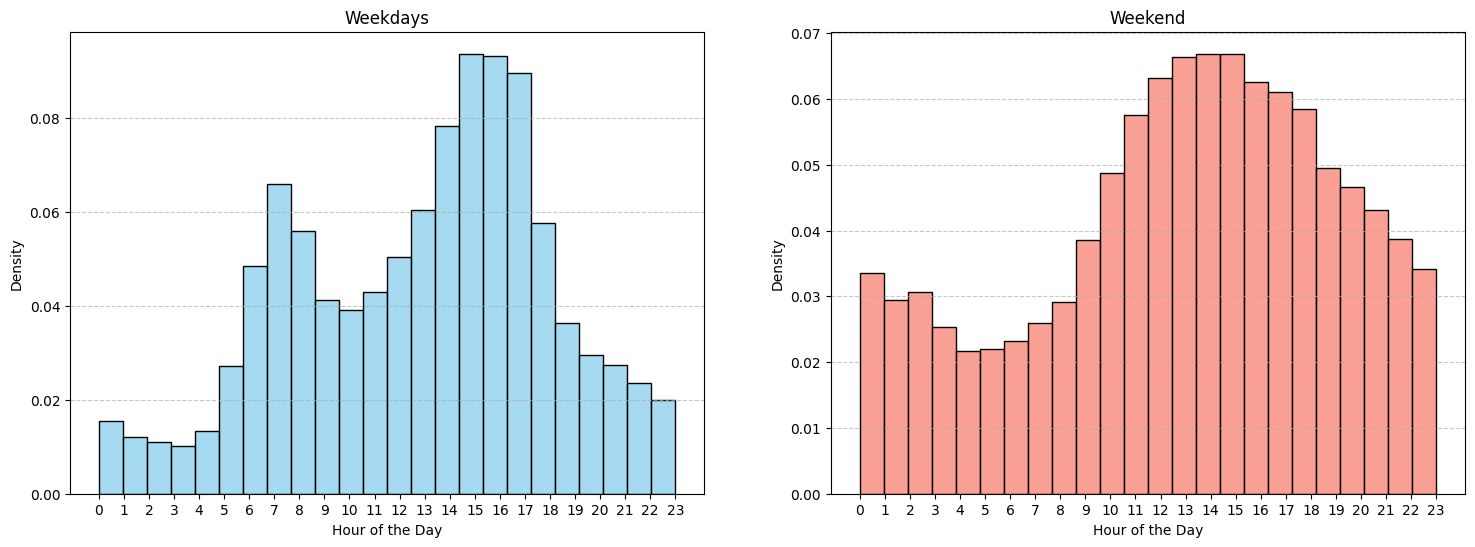

In [ ]:
weekday_hours = df_pd[df_pd['Weekday'] < 5]['Hour']
weekend_hours = df_pd[df_pd['Weekday'] >= 5]['Hour']

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(weekday_hours, bins=24, kde=False, color='skyblue', edgecolor='black', ax=ax[0], stat="density")
ax[0].set_title('Weekdays')
ax[0].set_xlabel('Hour of the Day')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].set_xticks(range(0, 24))

sns.histplot(weekend_hours, bins=24, kde=False, color='salmon', edgecolor='black', ax=ax[1], stat="density")
ax[1].set_title('Weekend')
ax[1].set_xlabel('Hour of the Day')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].set_xticks(range(0, 24))

plt.show();

<ipython-input-25-894dde95f312>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  c = sns.countplot(x="Month", data=df_pd, orient = 'v', palette = "crest")


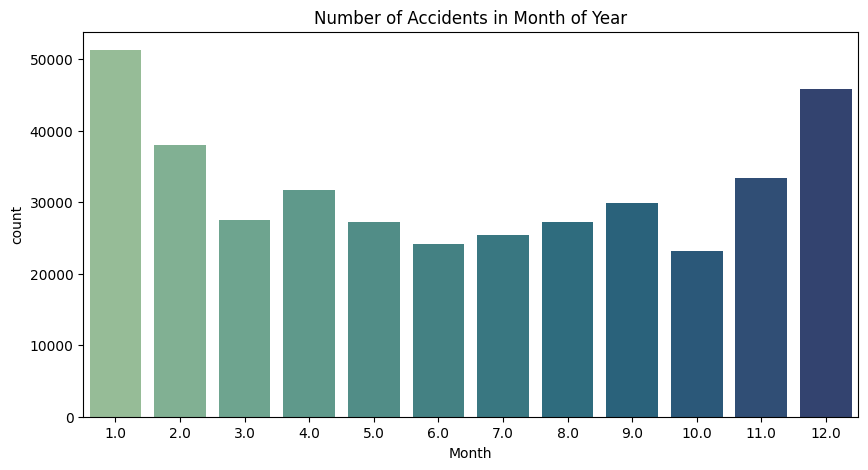

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
c = sns.countplot(x="Month", data=df_pd, orient = 'v', palette = "crest")
c.set_title("Number of Accidents in Month of Year")
plt.show();

In [ ]:
df.groupBy('Country').count().show()

+-------+-------+
|Country|  count|
+-------+-------+
|     US|3999646|
+-------+-------+



In [ ]:
df = df.drop('Country').drop('ID').drop('Description').drop('Weather_Timestamp')

In [ ]:
total_rows = df.count()

null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

null_percentages = null_counts.select([(col(c) / total_rows * 100).alias(c.replace('_Null_Count', '_Null_Percentage')) for c in null_counts.columns])

null_counts = null_counts.withColumn('id', lit(1))
null_percentages = null_percentages.withColumn('id', lit(1))
null_summary = null_counts.join(null_percentages, 'id').drop('id')

null_summary.show(truncate=False)

+------+--------+----------+--------+---------+---------+-------+-------+------------+------+----+------+-----+-------+--------+------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+------+--------+----------+--------+---------+---------+------------------+------------------+------------+-------------------+---------------------+------+-----+-------------------+-------------------+-------------------+------------------+------------------+----------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+-----------------

In [ ]:
columns = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
nulls_df = df.filter(df.Sunrise_Sunset.isNull())
nulls_df.select(columns).printSchema()


root
 |-- Sunrise_Sunset: string (nullable = true)
 |-- Civil_Twilight: string (nullable = true)
 |-- Nautical_Twilight: string (nullable = true)
 |-- Astronomical_Twilight: string (nullable = true)



In [ ]:
columns = ['End_Lat', 'End_Lng']
nulls_df = df.filter(df.End_Lat.isNull())
nulls_df.select(columns).printSchema()

root
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)



In [ ]:
columns = ['Start_Time', 'End_Time']
nulls_df = df.filter(df.Start_Time.isNull())
nulls_df.select(columns).printSchema()

root
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)



In [ ]:
cat_col = ['Source', 'Street', 'City', 'County', 'State', 'Zipcode', 'Timezone', 'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
num_col = ['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
bool_col = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
datetime_col = ['Start_Time', 'End_Time']

In [ ]:
df_pd = df.toPandas()

In [ ]:
def plot_boolean_features(df, bool_cols):
    num_features = len(bool_cols)
    num_rows = num_features // 2 + num_features % 2
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 24))

    axes = axes.flatten()

    for i, feature in enumerate(bool_cols):
        counts = df[feature].value_counts()
        counts.plot(kind='bar', ax=axes[i], color = 'green')
        axes[i].set_title(f'{feature}')
        axes[i].set_ylabel('Count')

    for j in range(num_features, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

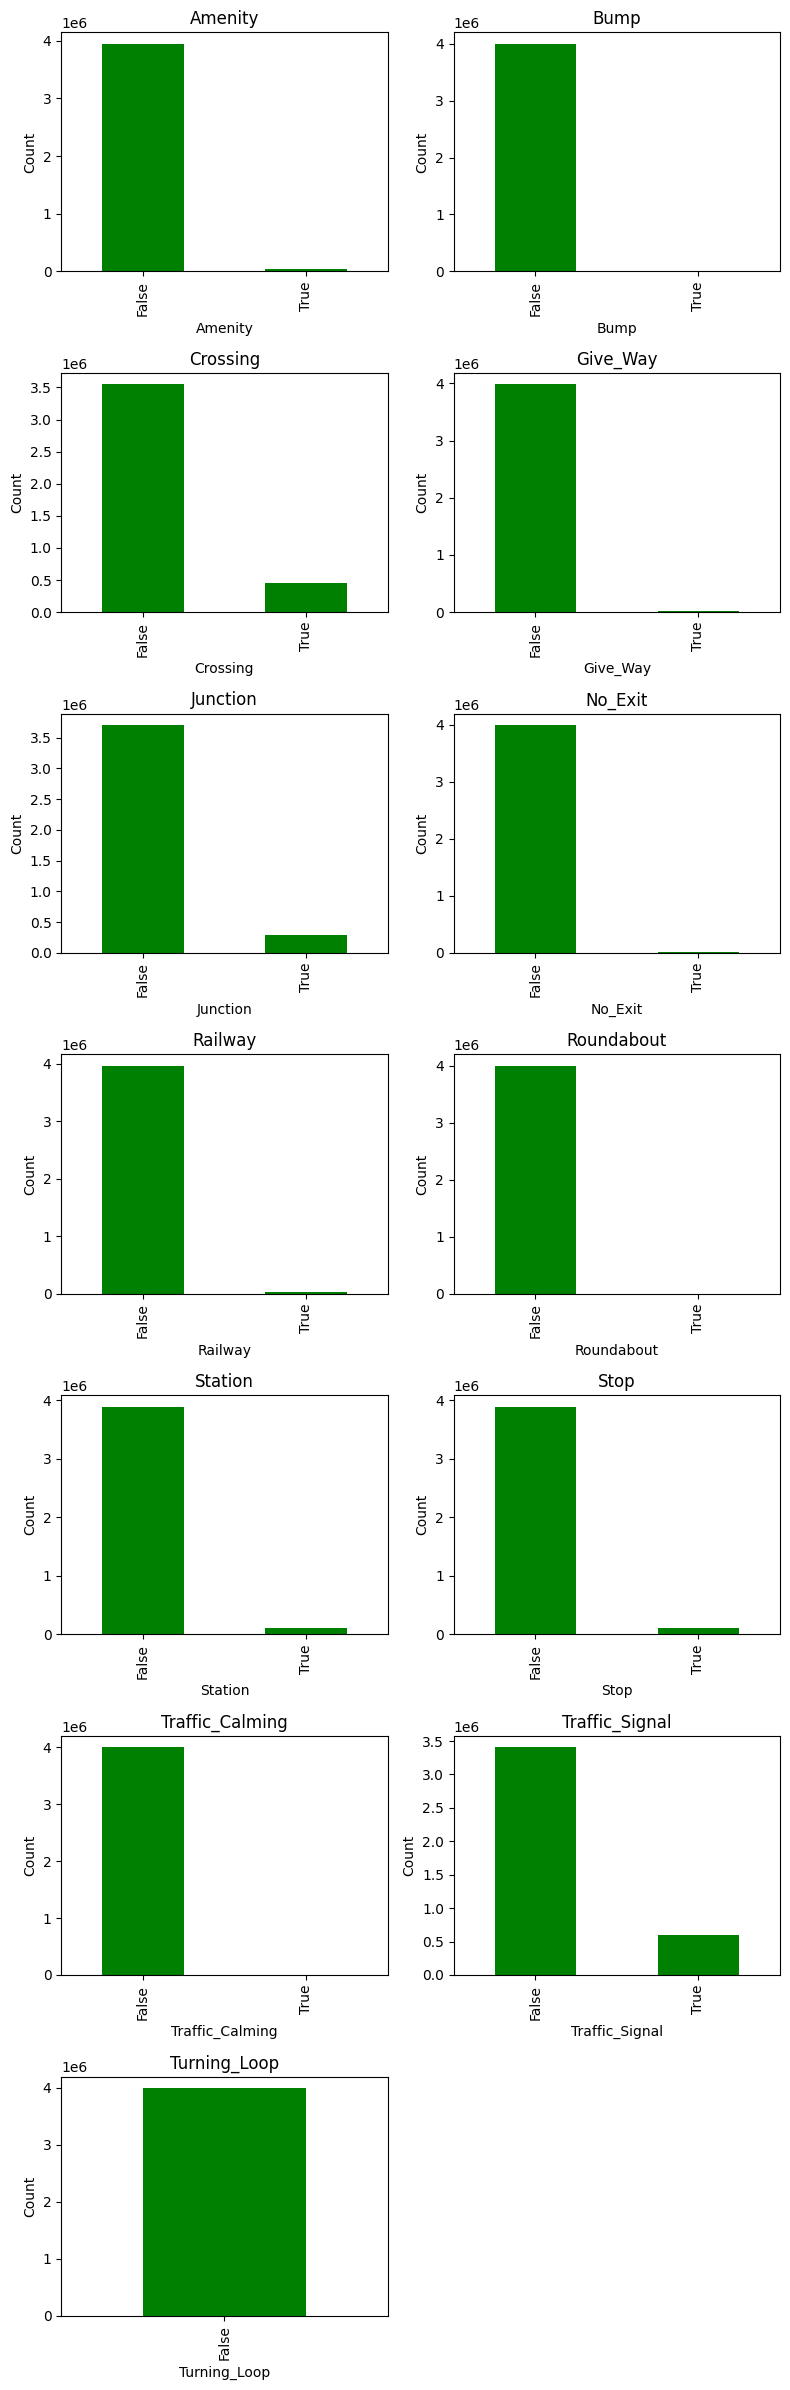

In [ ]:
plot_boolean_features(df_pd, bool_col)

In [ ]:
for column in bool_col:
    true_percentage = df.select(mean(col(column).cast('float'))).collect()[0][0] * 100
    false_percentage = 100 - true_percentage

    print(column)
    print(f"Percentage of True: {true_percentage:.2f}%")
    print(f"Percentage of False: {false_percentage:.2f}%")
    print()

Amenity
Percentage of True: 1.24%
Percentage of False: 98.76%

Bump
Percentage of True: 0.05%
Percentage of False: 99.95%

Crossing
Percentage of True: 11.31%
Percentage of False: 88.69%

Give_Way
Percentage of True: 0.47%
Percentage of False: 99.53%

Junction
Percentage of True: 7.40%
Percentage of False: 92.60%

No_Exit
Percentage of True: 0.25%
Percentage of False: 99.75%

Railway
Percentage of True: 0.87%
Percentage of False: 99.13%

Roundabout
Percentage of True: 0.00%
Percentage of False: 100.00%

Station
Percentage of True: 2.61%
Percentage of False: 97.39%

Stop
Percentage of True: 2.78%
Percentage of False: 97.22%

Traffic_Calming
Percentage of True: 0.10%
Percentage of False: 99.90%

Traffic_Signal
Percentage of True: 14.82%
Percentage of False: 85.18%

Turning_Loop
Percentage of True: 0.00%
Percentage of False: 100.00%



In [ ]:
df = df.drop('Turning_Loop').drop('Roundabout').drop('Bump').drop('Traffic_Calming').drop('No_Exit').drop('Give_Away')

In [ ]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+------+--------+----------+--------+---------+---------+-------+-------+------------+------+----+------+-----+-------+--------+------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+--------+--------+--------+-------+-------+----+--------------+--------------+--------------+-----------------+---------------------+
|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Street|City|County|State|Zipcode|Timezone|Airport_Code|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Crossing|Give_Way|Junction|Railway|Station|Stop|Traffic_Signal|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+------+--------+----------+--------+---------+---------+-------+-------+------------+------+----+------+-----+-------+--------+------------+--------------+------

In [ ]:
rare_category_counts = {}

for feature in cat_col:
    category_counts = df.groupBy(feature).count()
    category_counts = category_counts.withColumn('percentage', (col('count') / total_rows) * 100)

    rare_categories = category_counts.filter(col('percentage') < 1)
    total_rare_percentage = rare_categories.agg({'percentage': 'sum'}).collect()[0][0]

    rare_category_counts[feature] = total_rare_percentage if total_rare_percentage is not None else 0

for feature, percentage in rare_category_counts.items():
    print(f"Feature '{feature}': {percentage:.2f}% of categories are rare.")

Feature 'Source': 0.00% of categories are rare.
Feature 'Street': 98.98% of categories are rare.
Feature 'City': 86.09% of categories are rare.
Feature 'County': 66.81% of categories are rare.
Feature 'State': 7.96% of categories are rare.
Feature 'Zipcode': 100.00% of categories are rare.
Feature 'Timezone': 0.10% of categories are rare.
Feature 'Airport_Code': 90.09% of categories are rare.
Feature 'Wind_Direction': 0.00% of categories are rare.
Feature 'Weather_Condition': 5.18% of categories are rare.
Feature 'Sunrise_Sunset': 0.30% of categories are rare.
Feature 'Civil_Twilight': 0.30% of categories are rare.
Feature 'Nautical_Twilight': 0.30% of categories are rare.
Feature 'Astronomical_Twilight': 0.30% of categories are rare.


In [ ]:
def plot_categories(df, cat_cols):
    num_features = len(df[cat_cols].columns)
    num_rows = num_features // 2 + num_features % 2
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 50))

    axes = axes.flatten()

    for i, column in enumerate(df[cat_cols].columns):
        top_categories = df[column].value_counts().nlargest(50)
        top_categories.plot(kind='bar', ax=axes[i], color = 'green')
        axes[i].set_title(f'{column}')

    for j in range(num_features, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

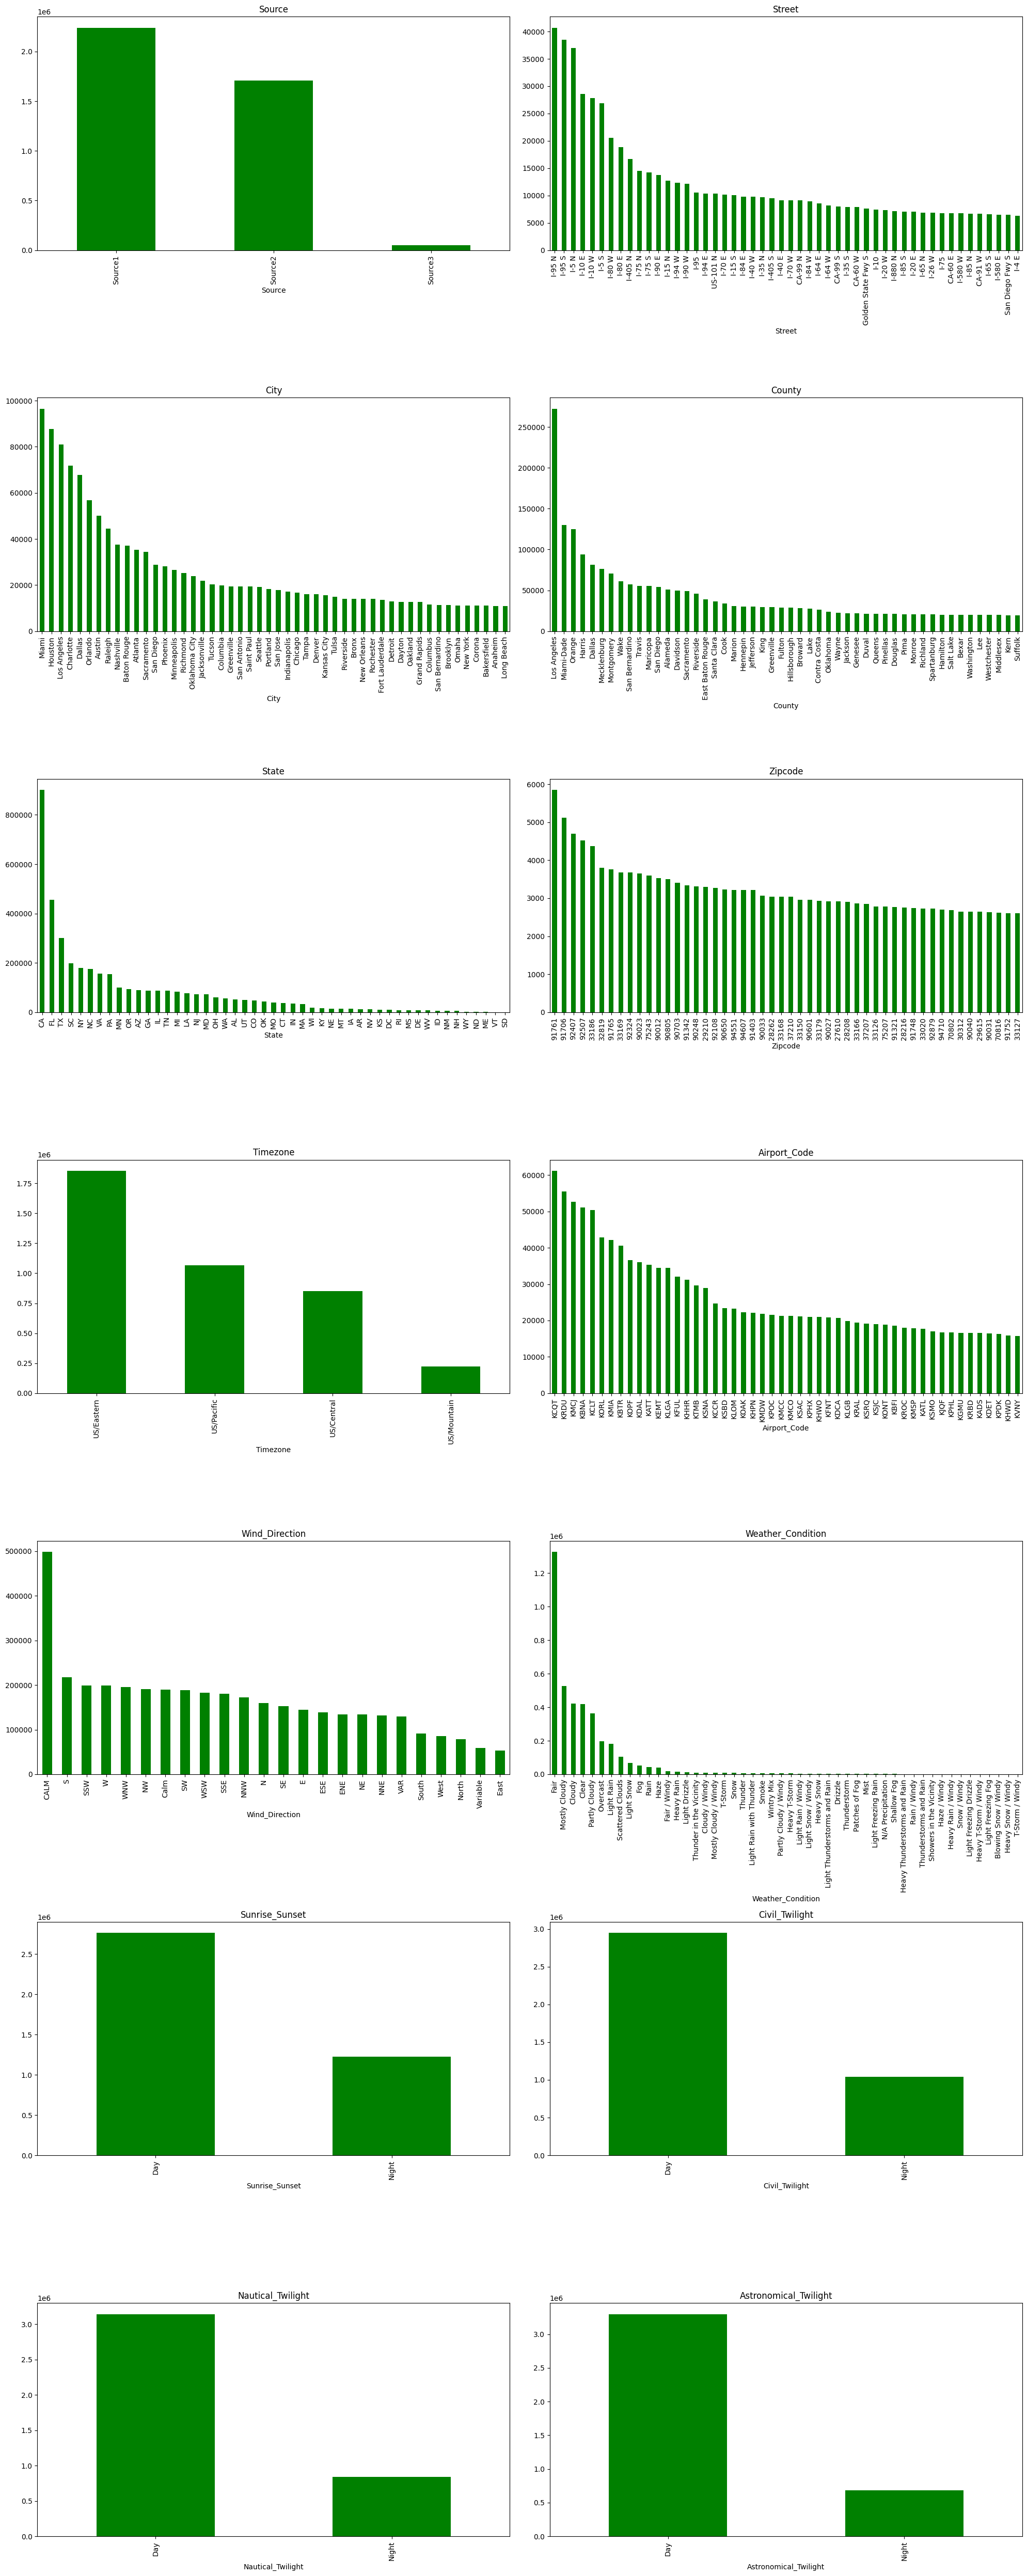

In [ ]:
plot_categories(df_pd, cat_col)

In [ ]:
df.groupby('Timezone').count().show()

+-----------+-------+
|   Timezone|  count|
+-----------+-------+
| US/Central| 850771|
|       null|   4025|
| US/Eastern|1852968|
| US/Pacific|1067709|
|US/Mountain| 224173|
+-----------+-------+



In [ ]:
from pyspark.sql.window import Window

window_spec = Window.partitionBy('County').orderBy(col('count').desc())

county_timezone = df.groupBy('County', 'Timezone') \
    .count() \
    .withColumn('row_number', row_number().over(window_spec)) \
    .filter(col('row_number') == 1) \
    .select('County', 'Timezone') \
    .withColumnRenamed('Timezone', 'New_Timezone')

df = df.join(county_timezone, on="County", how="left")

df = df.withColumn('Timezone', when(col('Timezone').isNull(), col('New_Timezone')).otherwise(col('Timezone')))

df = df.drop('New_Timezone')

In [ ]:
df = df.drop('Zipcode').drop('Street').drop('City').drop('County').drop('Airport_Code')

In [ ]:
civil_twilight = df.groupBy('Civil_Twilight').count().orderBy(desc('count')).first()[0]
nautical_twilight = df.groupBy('Nautical_Twilight').count().orderBy(desc('count')).first()[0]
astronomical_twilight = df.groupBy('Astronomical_Twilight').count().orderBy(desc('count')).first()[0]
sunrise_sunset = df.groupBy('Sunrise_Sunset').count().orderBy(desc('count')).first()[0]

df = df.withColumn('Civil_Twilight', when(col('Civil_Twilight').isNull(), civil_twilight).otherwise(col('Civil_Twilight')))
df = df.withColumn('Nautical_Twilight', when(col('Nautical_Twilight').isNull(), nautical_twilight).otherwise(col('Nautical_Twilight')))
df = df.withColumn('Astronomical_Twilight', when(col('Astronomical_Twilight').isNull(), astronomical_twilight).otherwise(col('Astronomical_Twilight')))
df = df.withColumn('Sunrise_Sunset', when(col('Sunrise_Sunset').isNull(), sunrise_sunset).otherwise(col('Sunrise_Sunset')))

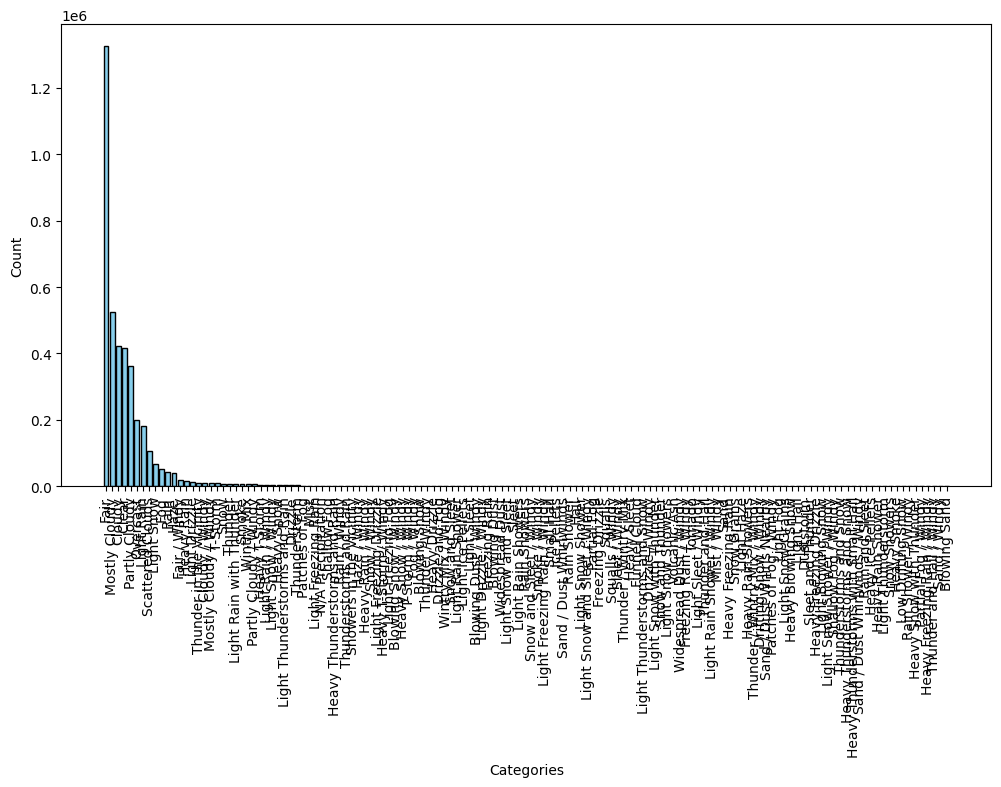

In [ ]:
weather_conditions = df_pd['Weather_Condition'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(weather_conditions.index, weather_conditions.values, color='skyblue', edgecolor='black')
plt.xlabel('Categories')
plt.xticks(rotation= 90)
plt.ylabel('Count')
plt.show();

In [ ]:
df.groupBy('Weather_Condition').count().show(30)

+--------------------+------+
|   Weather_Condition| count|
+--------------------+------+
|Light Rain Shower...|     7|
|        Thunderstorm|  2318|
|  Light Snow / Windy|  3540|
| Shallow Fog / Windy|     2|
|Showers in the Vi...|   790|
|   Heavy Ice Pellets|     2|
|              Cloudy|422616|
|     T-Storm / Windy|   431|
|               Sleet|    76|
|        Blowing Snow|   378|
|Sand / Dust Whirl...|     2|
|  Heavy Rain / Windy|   783|
|   Low Drifting Snow|     1|
|     Thunder / Windy|   301|
|Heavy Thunderstor...|     2|
|  Light Blowing Snow|     3|
|                null| 89999|
|     Widespread Dust|    92|
|         Partial Fog|    20|
|Thunder and Hail ...|     1|
|Light Rain with T...|  7112|
|       Heavy T-Storm|  5019|
|         Heavy Sleet|    15|
|Thunderstorms and...|  1169|
|      Cloudy / Windy|  8929|
|             Drizzle|  2370|
|        Snow Showers|     1|
|                 Fog| 51444|
|Light Snow Shower...|     3|
|        Mist / Windy|     7|
+---------

In [ ]:
def merge_weather_condition(condition):
    categories = ['Fair', 'Cloudy', 'Rain', 'Snow', 'Windy', 'Thunder', 'Smoke']
    words = [
        ['Clear'], ['Mist', 'Clouds', 'Cloud', 'Overcast'],
        ['Drizzle', 'Showers', 'Hail', 'Precipitation', 'Pellets', 'Squalls'], ['Wintry', 'Sleet'],
        ['Tornado', 'Fog', 'Haze'], ['T-Storm'], ['Dust', 'Sand']
    ]

    for i in range(len(categories)):
        if any(word.lower() in (condition or '').lower() for word in [categories[i]] + words[i]):
            return categories[i]

    return condition

merge_weather_condition_udf = udf(merge_weather_condition, StringType())

df = df.withColumn('Merged_Weather_Condition', merge_weather_condition_udf(df['Weather_Condition']))

df.select('Weather_Condition', 'Merged_Weather_Condition').show(10, truncate=False)

+-----------------+------------------------+
|Weather_Condition|Merged_Weather_Condition|
+-----------------+------------------------+
|Clear            |Fair                    |
|Clear            |Fair                    |
|Clear            |Fair                    |
|Overcast         |Cloudy                  |
|Light Rain       |Rain                    |
|Clear            |Fair                    |
|Clear            |Fair                    |
|Clear            |Fair                    |
|Overcast         |Cloudy                  |
|Overcast         |Cloudy                  |
+-----------------+------------------------+
only showing top 10 rows



In [ ]:
df.groupBy('Merged_Weather_Condition').count().show(30)

+------------------------+-------+
|Merged_Weather_Condition|  count|
+------------------------+-------+
|                  Cloudy|1640083|
|                    null|  89999|
|                    Fair|1761878|
|                 Thunder|  32301|
|            Volcanic Ash|     10|
|                   Smoke|   6783|
|                   Windy|  97811|
|                    Rain| 281312|
|                    Snow|  89469|
+------------------------+-------+



In [ ]:
df = df.drop('Weather_Condition')

In [ ]:
df = df.withColumnRenamed('Merged_Weather_Condition', 'Weather_Condition')

In [ ]:
weather_condition = df.groupBy('Weather_Condition').count().orderBy(desc('count')).first()[0]

df = df.withColumn('Weather_Condition', when(col('Weather_Condition').isNull(), weather_condition).otherwise(col('Weather_Condition')))

In [ ]:
df.groupBy('Wind_Direction').count().show(100)

+--------------+------+
|Wind_Direction| count|
+--------------+------+
|            SW|189109|
|          null| 90893|
|         South| 91243|
|             N|159217|
|             W|198645|
|             S|217881|
|            SE|152581|
|           NNE|132012|
|      Variable| 58946|
|         North| 79019|
|           SSE|180752|
|            NW|191086|
|          Calm|190114|
|             E|144367|
|           WSW|182686|
|           ENE|134045|
|            NE|133836|
|           NNW|172313|
|           SSW|198738|
|          East| 53624|
|           WNW|195977|
|          West| 85671|
|           VAR|129287|
|          CALM|498281|
|           ESE|139323|
+--------------+------+



In [ ]:
df = df.withColumn("Wind_Direction",
                   when(col("Wind_Direction") == "Calm", "CALM")
                   .when((col("Wind_Direction") == "West") | (col("Wind_Direction") == "WSW") | (col("Wind_Direction") == "WNW"), "W")
                   .when((col("Wind_Direction") == "South") | (col("Wind_Direction") == "SSW") | (col("Wind_Direction") == "SSE"), "S")
                   .when((col("Wind_Direction") == "North") | (col("Wind_Direction") == "NNW") | (col("Wind_Direction") == "NNE"), "N")
                   .when((col("Wind_Direction") == "East") | (col("Wind_Direction") == "ESE") | (col("Wind_Direction") == "ENE"), "E")
                   .when(col("Wind_Direction") == "Variable", "VAR")
                   .otherwise(col("Wind_Direction"))
                  )

In [ ]:
df.groupBy('Wind_Direction').count().show(100)

+--------------+------+
|Wind_Direction| count|
+--------------+------+
|            SW|189109|
|          null| 90893|
|             N|542561|
|             W|662979|
|             S|688614|
|            SE|152581|
|            NW|191086|
|             E|471359|
|            NE|133836|
|           VAR|188233|
|          CALM|688395|
+--------------+------+



In [ ]:
wind_direction = df.groupBy('Wind_Direction').count().orderBy(desc('count')).first()[0]

df = df.withColumn('Wind_Direction', when(col('Wind_Direction').isNull(), wind_direction).otherwise(col('Wind_Direction')))

In [ ]:
df.groupBy('Wind_Direction').count().show()

+--------------+------+
|Wind_Direction| count|
+--------------+------+
|            SW|189109|
|             N|542561|
|             W|662979|
|             S|779507|
|            SE|152581|
|            NW|191086|
|             E|471359|
|            NE|133836|
|           VAR|188233|
|          CALM|688395|
+--------------+------+



In [ ]:
df.groupBy('State').count().show(100)

+-----+------+
|State| count|
+-----+------+
|   AZ| 88524|
|   LA| 77404|
|   NJ| 72936|
|   VA|157061|
|   RI|  8773|
|   WY|  1986|
|   NH|  5303|
|   MI| 83951|
|   CA|901259|
|   CT| 36627|
|   MT| 14732|
|   MD| 72889|
|   DE|  7291|
|   MO| 39941|
|   IL| 87279|
|   WA| 56223|
|   IN| 34736|
|   TN| 86647|
|   IA| 13680|
|   SD|   149|
|   KS| 10978|
|   AR| 11793|
|   SC|198083|
|   MN| 99385|
|   DC|  9597|
|   OR| 92913|
|   KY| 16741|
|   NV| 11235|
|   WI| 17972|
|   ID|  5821|
|   NE| 14978|
|   NC|174999|
|   VT|   475|
|   ME|  1378|
|   ND|  1808|
|   MS|  7858|
|   AL| 52161|
|   OH| 61193|
|   NM|  5381|
|   PA|153796|
|   NY|180017|
|   TX|301150|
|   WV|  7106|
|   GA| 87703|
|   MA| 32059|
|   FL|454881|
|   CO| 47177|
|   OK| 43120|
|   UT| 50497|
+-----+------+



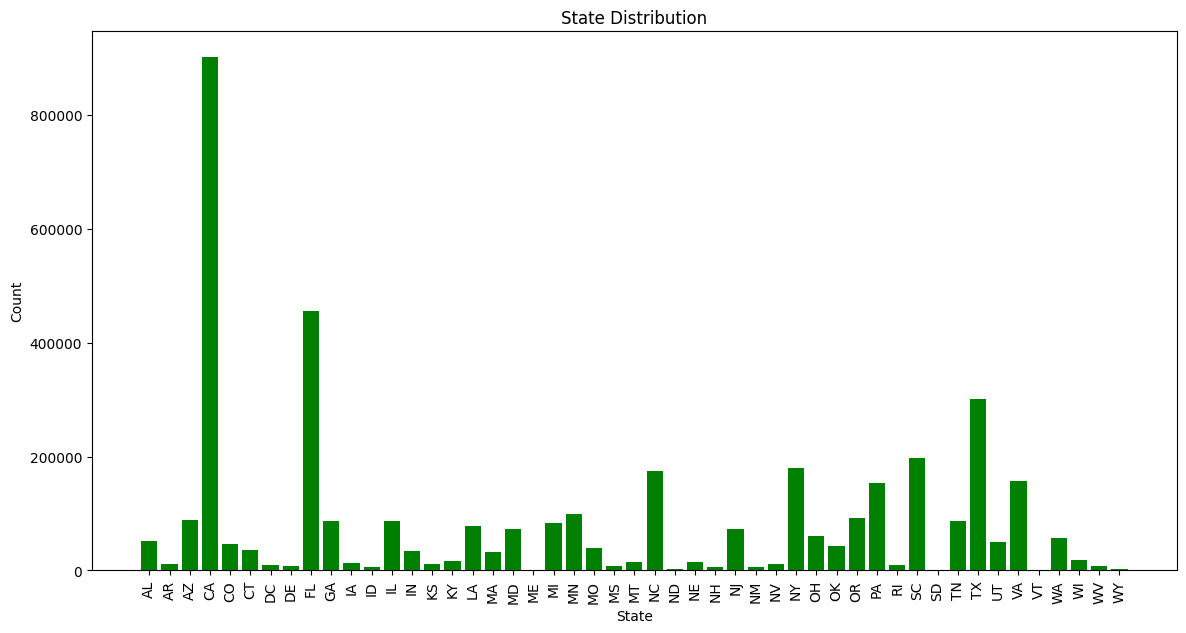

In [ ]:
state = df.groupBy("State").count().orderBy("State")

state_pd = state.toPandas()

plt.figure(figsize=(14, 7))
plt.bar(state_pd["State"], state_pd["count"], color='green')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('State Distribution')
plt.xticks(rotation=90)
plt.show();

In [ ]:
df = df.withColumn("State",
                   when(col("state").isin("WA", "OR", "CA", "NV", "ID", "MT", "WY", "UT", "CO", "AK", "HI"), "W")
                   .when(col("state").isin("ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "IN", "MI", "OH"), "MW")
                   .when(col("state").isin("AZ", "NM", "OK", "TX"), "SW")
                   .when(col("state").isin("AR", "LA", "MS", "AL", "GA", "FL", "SC", "NC", "VA", "WV", "KY", "TN"), "SE")
                   .when(col("state").isin("ME", "NH", "VT", "MA", "NY", "PA", "NJ", "CT", "RI", "DE", "MD", "DC"), "NE") )

In [ ]:
df.groupBy('State').count().show()

+-----+-------+
|State|  count|
+-----+-------+
|   SW| 438175|
|    W|1181843|
|   SE|1332437|
|   MW| 466050|
|   NE| 581141|
+-----+-------+



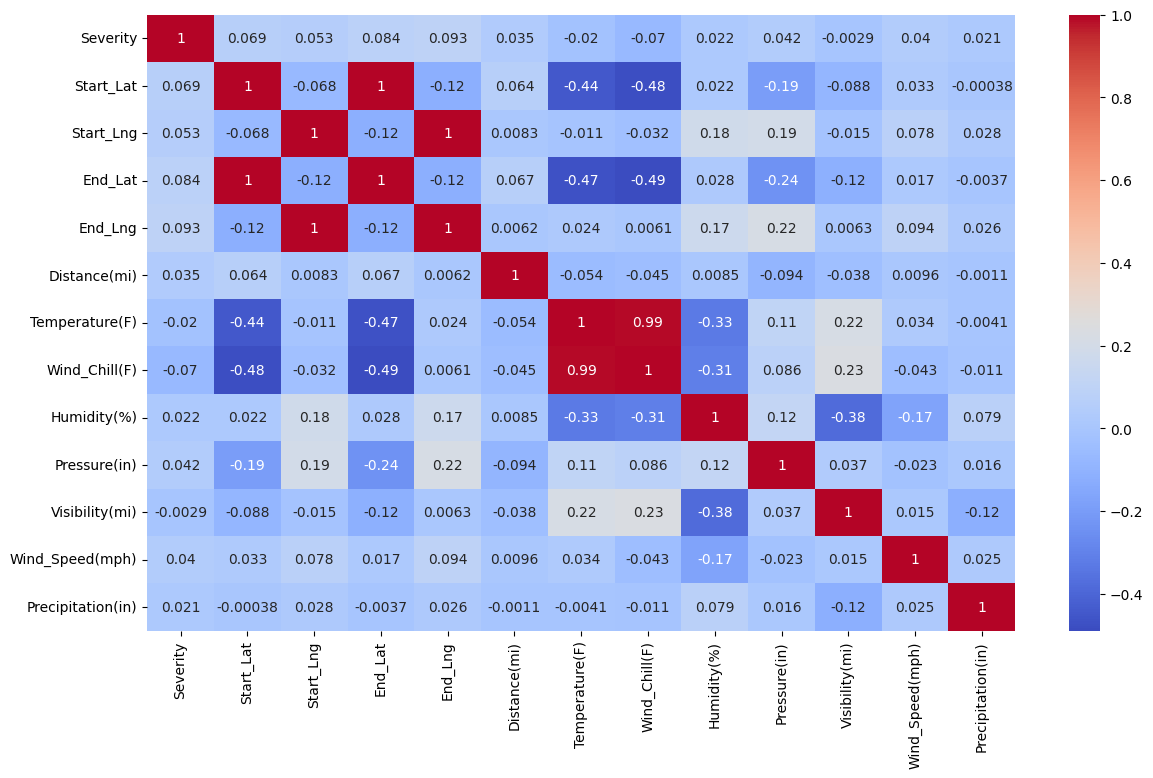

In [ ]:
corr = df_pd[num_col].corr()
plt.figure(figsize=(14, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show();

In [ ]:
def scatter_plot(df, feature1, feature2):
    plt.figure(figsize=(4, 4))
    x = df[feature1]
    y = df[feature2]
    plt.scatter(x, y, color='green', alpha=0.7)
    plt.title(f'{feature1} vs {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.grid(True)
    plt.show()

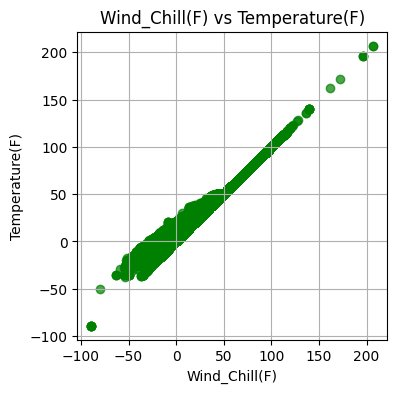

In [ ]:
scatter_plot(df_pd, "Wind_Chill(F)", "Temperature(F)")

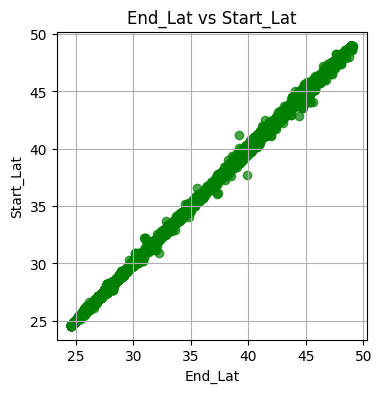

In [ ]:
scatter_plot(df_pd, "End_Lat", "Start_Lat")

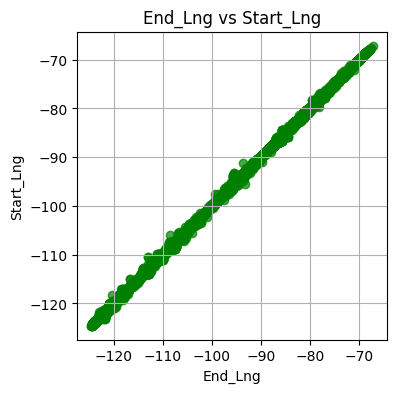

In [ ]:
scatter_plot(df_pd, "End_Lng", "Start_Lng")

In [ ]:
df = df.drop('End_Lat').drop( 'End_Lng').drop('Wind_Chill(F)')

In [ ]:
df = df.fillna(0, subset=["Temperature(F)"])
df = df.fillna(0, subset=["Wind_Speed(mph)"])
df = df.fillna(0, subset=["Humidity(%)"])
df = df.fillna(0, subset=["Visibility(mi)"])
df = df.fillna(0, subset=["Pressure(in)"])


In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=['Precipitation(in)'],outputCols=['Precipitation']).setStrategy('mean')

df = imputer.fit(df).transform(df)
df = df.drop('Precipitation(in)')

In [ ]:
df = df.withColumn('Start_Time', to_timestamp(col('Start_Time')))
df = df.withColumn('End_Time', to_timestamp(col('End_Time')))

df = df.withColumn('Time_Duration(min)', round((col('End_Time').cast('long') - col('Start_Time').cast('long')) / 60))

In [ ]:
df = df.drop('Start_Time').drop('End_Time')

In [ ]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+------+--------+---------+---------+------------+-----+--------+--------------+-----------+------------+--------------+--------------+---------------+-------+--------+--------+--------+-------+-------+----+--------------+--------------+--------------+-----------------+---------------------+-----------------+-------------+------------------+
|Source|Severity|Start_Lat|Start_Lng|Distance(mi)|State|Timezone|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Amenity|Crossing|Give_Way|Junction|Railway|Station|Stop|Traffic_Signal|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|Weather_Condition|Precipitation|Time_Duration(min)|
+------+--------+---------+---------+------------+-----+--------+--------------+-----------+------------+--------------+--------------+---------------+-------+--------+--------+--------+-------+-------+----+--------------+--------------+--------------+-----------------+---------------------+-----------------+--

In [ ]:
df.printSchema()

root
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- State: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Temperature(F): double (nullable = false)
 |-- Humidity(%): double (nullable = false)
 |-- Pressure(in): double (nullable = false)
 |-- Visibility(mi): double (nullable = false)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): double (nullable = false)
 |-- Amenity: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Give_Way: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nullable = true)
 |-- Sunrise_Sunset: string (nullable = true)
 |-- Civil_Twilight: string (nullable = true)
 |-- Nautical_Twi

In [ ]:
df.count()

3999646

In [ ]:
cat_col = ['Source', 'Timezone', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'State','Wind_Direction']
num_col = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Time_Duration(min)', 'Precipitation']
bool_col = ['Amenity', 'Crossing', 'Give_Way', 'Junction', 'Railway', 'Station', 'Stop', 'Traffic_Signal']

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=column, outputCol=column + "_n") for column in cat_col]

pipeline = Pipeline(stages=indexers)

df = pipeline.fit(df).transform(df)

In [ ]:
df = df.drop(*cat_col)

In [ ]:
df.select(bool_col).show(10)

+-------+--------+--------+--------+-------+-------+-----+--------------+
|Amenity|Crossing|Give_Way|Junction|Railway|Station| Stop|Traffic_Signal|
+-------+--------+--------+--------+-------+-------+-----+--------------+
|  false|    true|   false|   false|  false|  false|false|          true|
|  false|   false|   false|    true|  false|  false|false|         false|
|  false|   false|   false|   false|  false|  false|false|         false|
|  false|   false|   false|   false|  false|  false|false|         false|
|  false|   false|   false|   false|  false|  false|false|         false|
|  false|   false|   false|   false|  false|  false|false|          true|
|  false|   false|   false|   false|  false|  false|false|         false|
|  false|   false|   false|   false|  false|  false|false|         false|
|  false|   false|   false|   false|  false|  false|false|         false|
|  false|    true|   false|   false|  false|  false|false|          true|
+-------+--------+--------+--------+--

In [ ]:
for column in bool_col:
    df = df.withColumn(column, when(col(column) == True, 1).otherwise(0))

In [ ]:
df.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Temperature(F): double (nullable = false)
 |-- Humidity(%): double (nullable = false)
 |-- Pressure(in): double (nullable = false)
 |-- Visibility(mi): double (nullable = false)
 |-- Wind_Speed(mph): double (nullable = false)
 |-- Amenity: integer (nullable = false)
 |-- Crossing: integer (nullable = false)
 |-- Give_Way: integer (nullable = false)
 |-- Junction: integer (nullable = false)
 |-- Railway: integer (nullable = false)
 |-- Station: integer (nullable = false)
 |-- Stop: integer (nullable = false)
 |-- Traffic_Signal: integer (nullable = false)
 |-- Precipitation: double (nullable = true)
 |-- Time_Duration(min): double (nullable = true)
 |-- Source_n: double (nullable = false)
 |-- Timezone_n: double (nullable = false)
 |-- Weather_Condition_n: double (nullable = false)
 |-- Sunrise_Sunset_n: double (

In [ ]:
from pyspark.sql.functions import col

for column in num_col:

    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    print(f'Outliers {column}:')
    outliers.select(column).show(100)

Outliers Start_Lat:
+---------+
|Start_Lat|
+---------+
+---------+

Outliers Start_Lng:
+---------+
|Start_Lng|
+---------+
+---------+

Outliers Distance(mi):
+------------------+
|      Distance(mi)|
+------------------+
|              8.59|
|              3.05|
|              3.94|
|               2.5|
|              3.01|
|             13.36|
|             13.27|
|             13.27|
|              3.91|
|              7.33|
|              1.54|
|              1.54|
|              1.54|
|              1.53|
|               1.2|
|               1.2|
|               2.6|
|              8.59|
|              1.68|
|             13.62|
|              2.24|
|              8.59|
|              8.17|
|               2.6|
| 21.90999984741211|
| 21.90999984741211|
| 4.849999904632568|
| 21.90999984741211|
| 21.90999984741211|
| 4.190000057220459|
| 6.340000152587893|
| 4.019999980926514|
|13.720000267028807|
| 22.06999969482422|
| 22.06999969482422|
|21.790000915527344|
|5.0900001525878915|

In [ ]:
from pyspark.sql import functions as F
from functools import reduce

def find_outliers(df):
    # Veri setindeki sayısal columnlar.
    num_cols = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Time_Duration(min)', 'Precipitation']

    # Her column'un ayrı ayrı Q1 ve Q3 değerlerirni hesaplar.
    for column in num_cols:
        # Q1 : First Quartile, Q3 : Third Quartile
        Q1 = df.approxQuantile(column, [0.25], relativeError=0)
        Q3 = df.approxQuantile(column, [0.75], relativeError=0)

        # IQR : Interquartile Range
        IQR = Q3[0] - Q1[0]

        # Sınır değerleri hesaplanır.
        less_Q1 = Q1[0] - 1.5 * IQR
        more_Q3 = Q3[0] + 1.5 * IQR

        outlier_col = f'is_outlier_{column}'

        # Eğer column sütunundaki değer, üçüncü çeyreğin üst sınırından (more_Q3) büyükse veya birinci çeyreğin alt sınırından (less_Q1) küçükse, bu ifade 1 değerini döndürür, yani bu kaydı outlier olarak işaretler.
        df = df.withColumn(outlier_col, F.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))

    outlier_columns = [f'is_outlier_{column}' for column in num_cols]

    # Her column'daki outlier değerlerin toplamını total_outliers_col sütünunda toplar.
    total_outliers_col = reduce(lambda x, y: x + y, (F.col(x) for x in outlier_columns))
    df = df.withColumn('total_outliers', total_outliers_col)

    # outlier_columns sütununu veri setinden atar.
    df = df.drop(*outlier_columns)

    return df

In [ ]:
new_df = find_outliers(df)
outliers = new_df.groupBy("total_outliers").count().orderBy(col("count").desc())
outliers.show()

+--------------+-------+
|total_outliers|  count|
+--------------+-------+
|             0|2319561|
|             1|1172959|
|             2| 357021|
|             3| 122123|
|             4|  24969|
|             5|   2994|
|             6|     19|
+--------------+-------+



In [ ]:
new_no_outliers = new_df.filter(new_df['total_outliers']<=1)
new_df_no_outliers = new_no_outliers.select(*new_df.columns)

new_df_no_outliers.columns

['Severity',
 'Start_Lat',
 'Start_Lng',
 'Distance(mi)',
 'Temperature(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Amenity',
 'Crossing',
 'Give_Way',
 'Junction',
 'Railway',
 'Station',
 'Stop',
 'Traffic_Signal',
 'Precipitation',
 'Time_Duration(min)',
 'Source_n',
 'Timezone_n',
 'Weather_Condition_n',
 'Sunrise_Sunset_n',
 'Civil_Twilight_n',
 'Nautical_Twilight_n',
 'Astronomical_Twilight_n',
 'State_n',
 'Wind_Direction_n',
 'total_outliers']

In [ ]:
df = new_df_no_outliers

In [ ]:
df = df.drop('total_outliers')

In [ ]:
df.count() # Outlier'lar atıldıktan sonra veri setinin boyutu.

3492520

In [ ]:
df.show()

+--------+------------------+------------------+------------+--------------+-----------+------------+--------------+---------------+-------+--------+--------+--------+-------+-------+----+--------------+--------------------+------------------+--------+----------+-------------------+----------------+----------------+-------------------+-----------------------+-------+----------------+
|Severity|         Start_Lat|         Start_Lng|Distance(mi)|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Amenity|Crossing|Give_Way|Junction|Railway|Station|Stop|Traffic_Signal|       Precipitation|Time_Duration(min)|Source_n|Timezone_n|Weather_Condition_n|Sunrise_Sunset_n|Civil_Twilight_n|Nautical_Twilight_n|Astronomical_Twilight_n|State_n|Wind_Direction_n|
+--------+------------------+------------------+------------+--------------+-----------+------------+--------------+---------------+-------+--------+--------+--------+-------+-------+----+--------------+--------------------+--

In [ ]:
df_pd = df.toPandas()

In [ ]:
def plot_kde(df, num_cols):
    num_features = len(df[num_cols].columns)
    num_rows = num_features // 2 + num_features % 2
    num_cols_per_row = 2

    fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(20,20))

    axes = axes.flatten()

    for i, column in enumerate(df[num_cols].columns):
        sns.kdeplot(df[column], ax=axes[i], color='blue', fill=True)
        axes[i].set_title(f'{column}')

    for j in range(num_features, num_rows * num_cols_per_row):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show();

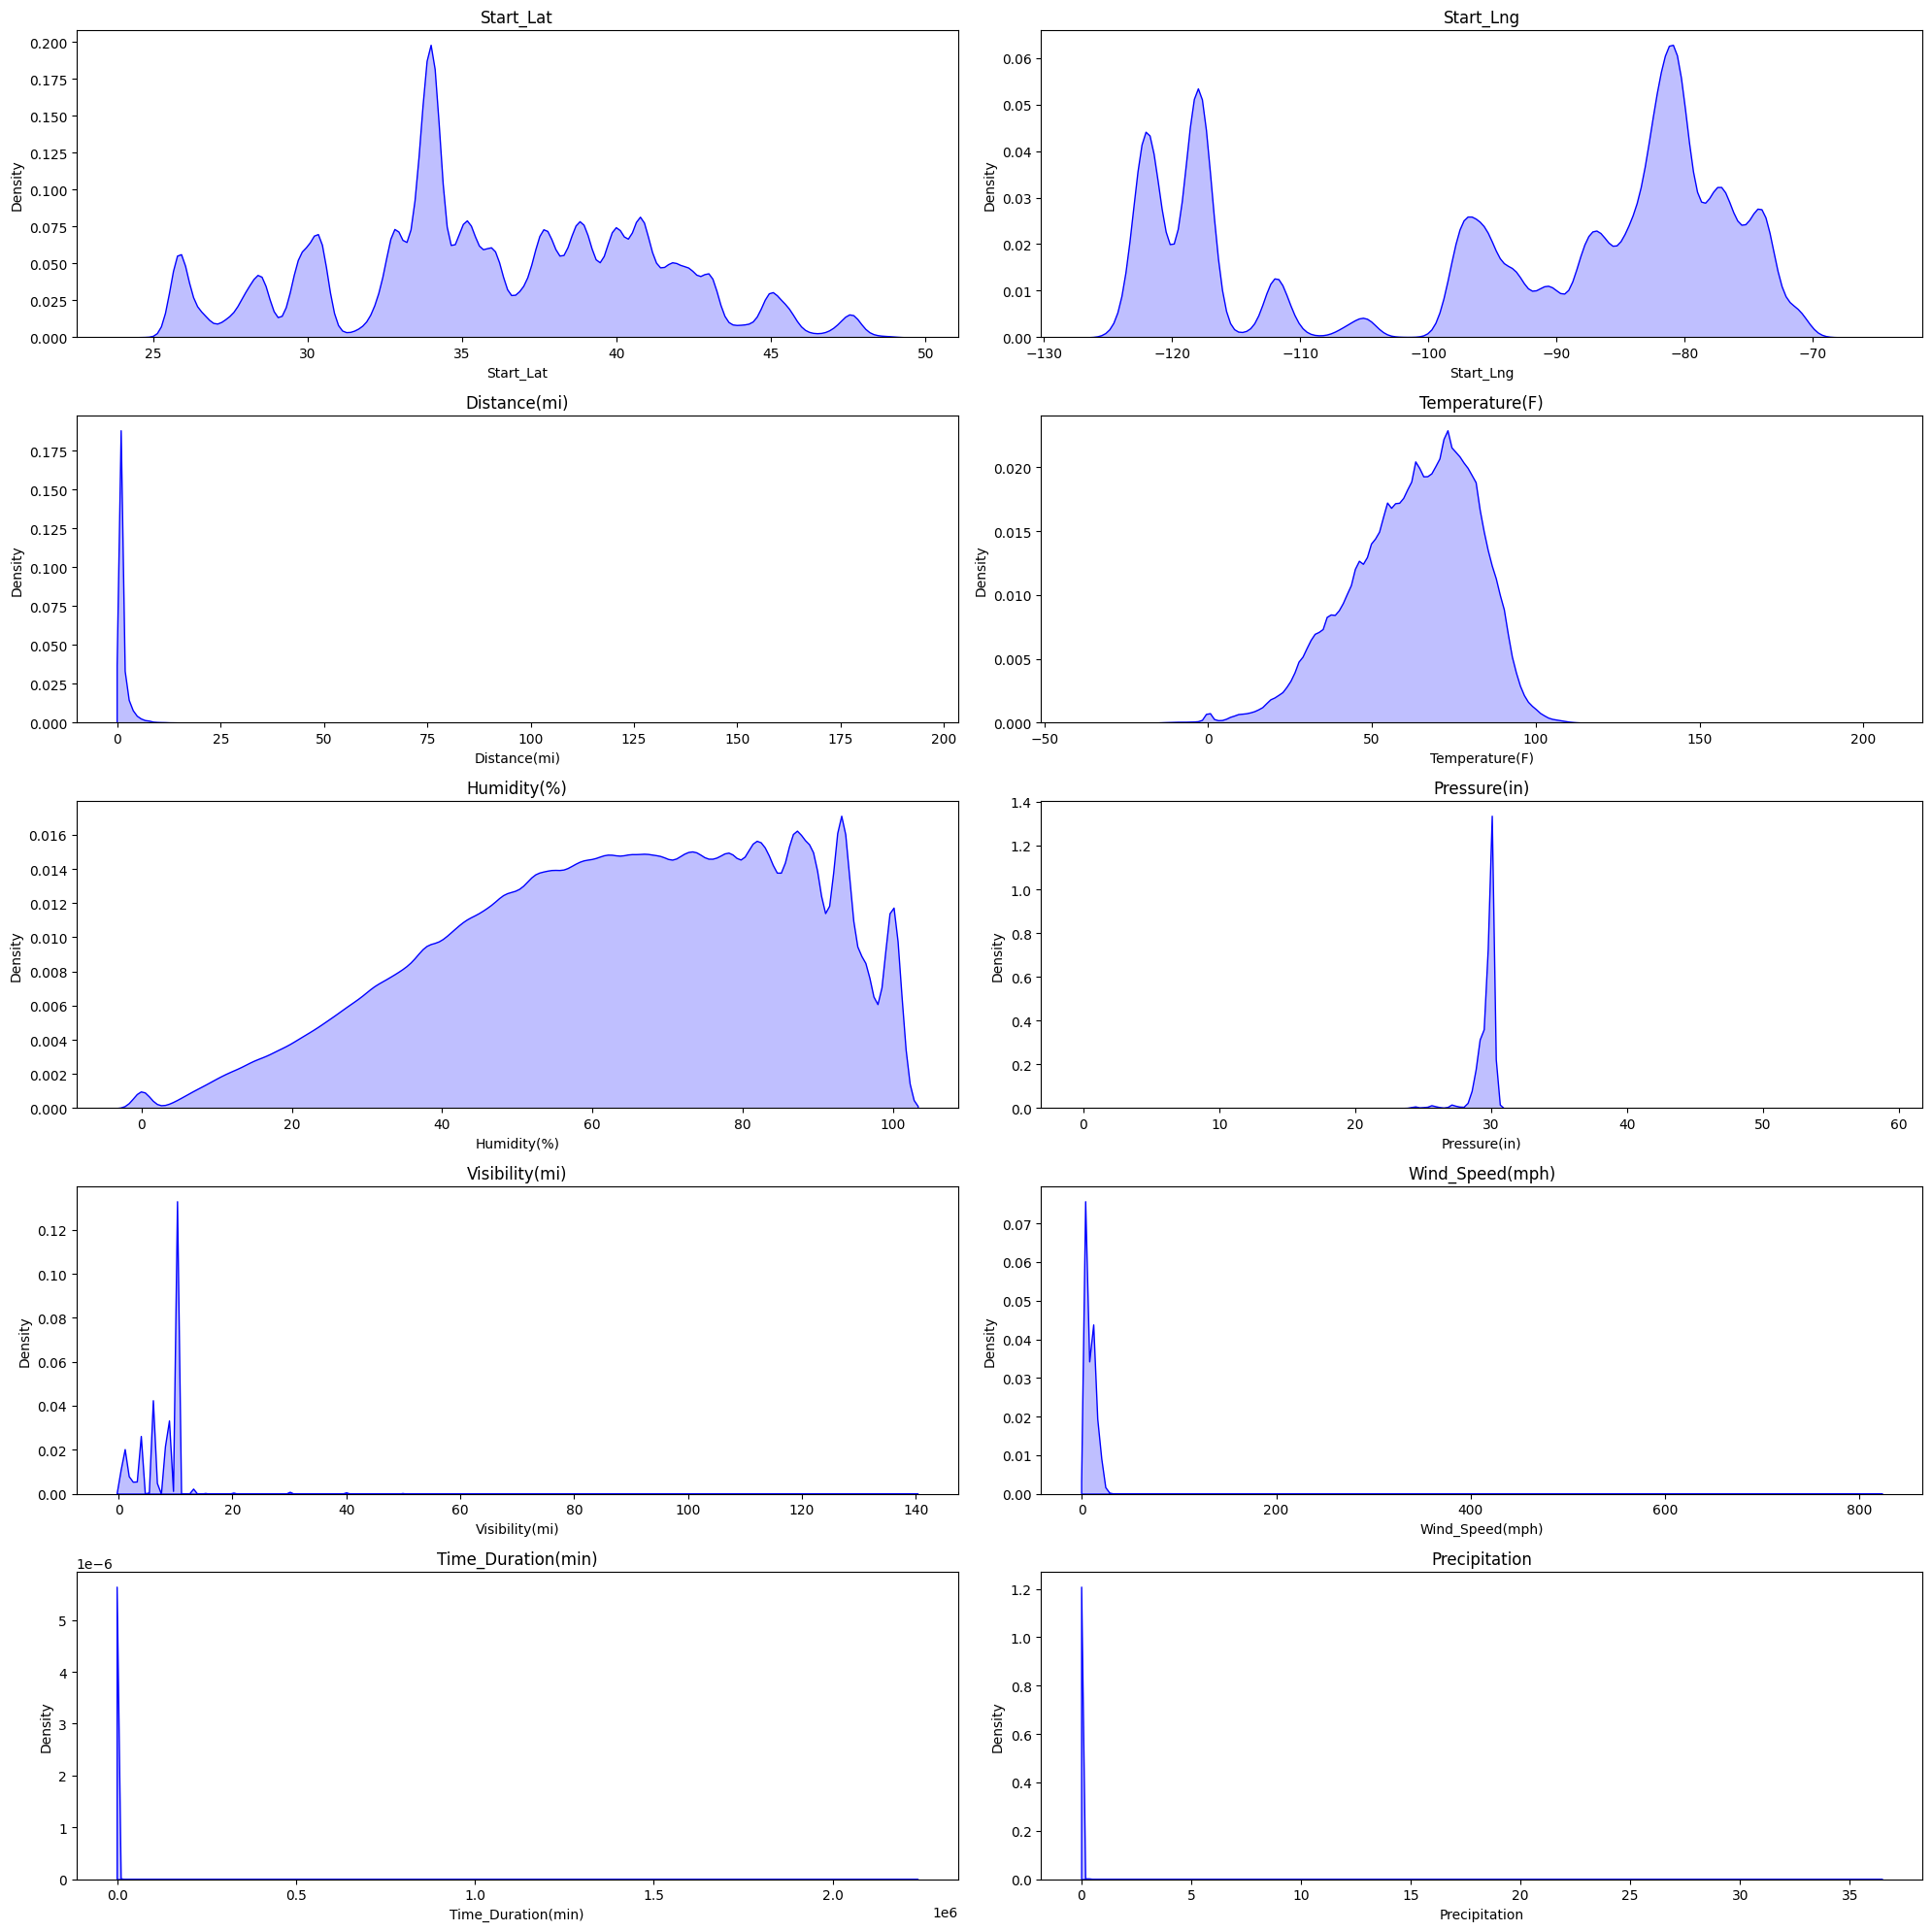

In [ ]:
plot_kde(df_pd,num_col)

In [ ]:
splits = df.randomSplit([0.8, 0.2],seed=0)
train = splits[0]
test = splits[1]

In [ ]:
train.count()

2794305

In [ ]:
test.count()

698215

In [ ]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["Start_Lat"], outputCol="Start_Lat_vec")
train = assembler.transform(train)
test = assembler.transform(test)

scaler = MinMaxScaler(inputCol="Start_Lat_vec", outputCol="Start_Lat_s")
scaler_model = scaler.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)

In [ ]:
train.select('Start_Lat','Start_Lat_s').show()

+------------------+--------------------+
|         Start_Lat|         Start_Lat_s|
+------------------+--------------------+
|         38.342411|[0.5638732662751403]|
|40.158089000000004|[0.6381585679214288]|
|40.190028999999996|[0.6394653373676531]|
|         40.229118|[0.6410645956921204]|
|         40.289001|[0.6435146042941328]|
|          40.30275|[0.6440771206722213]|
|         40.353626|[0.6461586235634588]|
|           40.4358|[0.6495206295895726]|
|           40.4358|[0.6495206295895726]|
|         42.027771|[0.7146533491285784]|
|         42.051479|[0.7156233206386314]|
|         42.060177|[0.7159791841528226]|
|         42.074619|[0.7165700534183946]|
|42.115959000000004|[0.7182614074856125]|
|          42.12075|[0.7184574229025461]|
|42.129630999999996|[0.7188207735428691]|
|          42.13901|[0.7192044989854535]|
|         42.145096|[0.7194534970709178]|
|          42.14539| [0.719465525568638]|
|         42.153469|[0.7197960637764043]|
+------------------+--------------

In [ ]:
train = train.drop('Start_Lat_vec').drop('Start_Lat')
test = test.drop('Start_Lat_vec').drop('Start_Lat')

In [ ]:
train = train.withColumnRenamed('Start_Lat_s','Start_Lat')
test = test.withColumnRenamed('Start_Lat_s','Start_Lat')

In [ ]:
assembler = VectorAssembler(inputCols=["Start_Lng"], outputCol="Start_Lng_vec")
train = assembler.transform(train)
test = assembler.transform(test)

scaler = MinMaxScaler(inputCol="Start_Lng_vec", outputCol="Start_Lng_s")
scaler_model = scaler.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)

In [ ]:
train.select('Start_Lng','Start_Lng_s').show()

+------------------+--------------------+
|         Start_Lng|         Start_Lng_s|
+------------------+--------------------+
|-75.16194899999998|[0.8598625396921079]|
|        -75.048859|[0.8618315513247025]|
|        -75.103111|[0.8608869689647101]|
|        -75.167938|[0.8597582651261192]|
|-75.26798199999998|[0.8580163975890138]|
|         -75.29126|[0.8576111039929083]|
|        -75.301338|[0.8574356357885285]|
|         -75.42453|[0.8552907380872055]|
|         -75.42453|[0.8552907380872055]|
|        -71.938347| [0.915988720935859]|
|        -71.879311|[0.9170165975893372]|
|        -71.859421| [0.917362902668233]|
|        -72.032913|[0.9143422309363192]|
|        -71.796913|[0.9184512303641408]|
|        -71.864273|[0.9172784244257592]|
|        -71.530251| [0.923094086319318]|
|         -72.02903|[0.9144098379057183]|
|        -71.990356|[0.9150831914814453]|
|-71.86595200000002|[0.9172491913323719]|
|         -71.52285|[0.9232229452378151]|
+------------------+--------------

In [ ]:
train = train.drop('Start_Lng_vec').drop('Start_Lng')
test = test.drop('Start_Lng_vec').drop('Start_Lng')

train = train.withColumnRenamed('Start_Lng_s','Start_Lng')
test = test.withColumnRenamed('Start_Lng_s','Start_Lng')

In [ ]:
train.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Temperature(F): double (nullable = false)
 |-- Humidity(%): double (nullable = false)
 |-- Pressure(in): double (nullable = false)
 |-- Visibility(mi): double (nullable = false)
 |-- Wind_Speed(mph): double (nullable = false)
 |-- Amenity: integer (nullable = false)
 |-- Crossing: integer (nullable = false)
 |-- Give_Way: integer (nullable = false)
 |-- Junction: integer (nullable = false)
 |-- Railway: integer (nullable = false)
 |-- Station: integer (nullable = false)
 |-- Stop: integer (nullable = false)
 |-- Traffic_Signal: integer (nullable = false)
 |-- Precipitation: double (nullable = true)
 |-- Time_Duration(min): double (nullable = true)
 |-- Source_n: double (nullable = false)
 |-- Timezone_n: double (nullable = false)
 |-- Weather_Condition_n: double (nullable = false)
 |-- Sunrise_Sunset_n: double (nullable = false)
 |-- Civil_Twilight_n: double (nullable = false)
 |-- Nautical_T

In [ ]:
from pyspark.sql.functions import log

train = train.withColumn("Distance(mi)", log(train["Distance(mi)"] + 1))
test = test.withColumn("Distance(mi)", log(test["Distance(mi)"] + 1))

In [ ]:
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=["Temperature(F)"], outputCol="Temperature_vec")
train = assembler.transform(train)
test = assembler.transform(test)

scaler = StandardScaler(inputCol="Temperature_vec", outputCol="Temperature_s", withMean=True, withStd=True)
scaler_model = scaler.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)

In [ ]:
train = train.drop('Temperature_vec').drop('Temperature(F)')
test = test.drop('Temperature_vec').drop('Temperature(F)')

train = train.withColumnRenamed('Temperature_s','Temperature(F)')
test = test.withColumnRenamed('Temperature_s','Temperature(F)')

In [ ]:
assembler = VectorAssembler(inputCols=["Humidity(%)"], outputCol="Humidity_vec")
train = assembler.transform(train)
test = assembler.transform(test)

scaler = StandardScaler(inputCol="Humidity_vec", outputCol="Humidity_scaled", withMean=True, withStd=True)
scaler_model = scaler.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)

In [ ]:
train = train.drop('Humidity_vec').drop('Humidity(%)')
test = test.drop('Humidity_vec').drop('Humidity(%)')

train = train.withColumnRenamed('Humidity_scaled','Humidity(%)')
test = test.withColumnRenamed('Humidity_scaled','Humidity(%)')

In [ ]:
assembler = VectorAssembler(inputCols=["Pressure(in)"], outputCol="Pressure_vec")
train = assembler.transform(train)
test = assembler.transform(test)

scaler = StandardScaler(inputCol="Pressure_vec", outputCol="Pressure_s", withMean=True, withStd=True)
scaler_model = scaler.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)

In [ ]:
train = train.drop('Pressure_vec').drop('Pressure(in)')
test = test.drop('Pressure_vec').drop('Pressure(in)')

train = train.withColumnRenamed('Pressure_s','Pressure(in)')
test = test.withColumnRenamed('Pressure_s','Pressure(in)')

In [ ]:
train = train.withColumn("Visibility(mi)", log(train["Visibility(mi)"] + 1))
test = test.withColumn("Visibility(mi)", log(test["Visibility(mi)"] + 1))

In [ ]:
train = train.withColumn("Wind_Speed(mph)", log(train["Wind_Speed(mph)"] + 1))
test = test.withColumn("Wind_Speed(mph)", log(test["Wind_Speed(mph)"] + 1))

In [ ]:
train = train.withColumn("Time_Duration(min)", log(train["Time_Duration(min)"] + 1))
test = test.withColumn("Time_Duration(min)", log(test["Time_Duration(min)"] + 1))

In [ ]:
train = train.withColumn("Precipitation", log(train["Precipitation"] + 1))
test = test.withColumn("Precipitation", log(test["Precipitation"] + 1))

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[
    'Amenity', 'Crossing', 'Give_Way', 'Junction','Railway','Precipitation',
    'Station', 'Stop','Traffic_Signal','Sunrise_Sunset_n',
    'Civil_Twilight_n', 'Nautical_Twilight_n', 'Astronomical_Twilight_n',
    'Time_Duration(min)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Source_n',
    'Timezone_n', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Weather_Condition_n', 'State_n'], outputCol='features')

train = assembler.transform(train)
test = assembler.transform(test)

In [ ]:
train.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Amenity: integer (nullable = false)
 |-- Crossing: integer (nullable = false)
 |-- Give_Way: integer (nullable = false)
 |-- Junction: integer (nullable = false)
 |-- Railway: integer (nullable = false)
 |-- Station: integer (nullable = false)
 |-- Stop: integer (nullable = false)
 |-- Traffic_Signal: integer (nullable = false)
 |-- Precipitation: double (nullable = true)
 |-- Time_Duration(min): double (nullable = true)
 |-- Source_n: double (nullable = false)
 |-- Timezone_n: double (nullable = false)
 |-- Weather_Condition_n: double (nullable = false)
 |-- Sunrise_Sunset_n: double (nullable = false)
 |-- Civil_Twilight_n: double (nullable = false)
 |-- Nautical_Twilight_n: double (nullable = false)
 |-- Astronomical_Twilight_n: double (nullable = false)
 |-- State_n: double (nullable = false)
 |-- 

In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
models = [
    LogisticRegression(featuresCol='features', labelCol='Severity'),
    DecisionTreeClassifier(featuresCol='features', labelCol='Severity'),
    RandomForestClassifier(featuresCol='features', labelCol='Severity'),
]

best_model = None
best_accuracy = 0.0

for model in models:
    model_name = model.__class__.__name__

    modell = model.fit(train)

    train_predictions = modell.transform(train)
    train_evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
    train_accuracy = train_evaluator.evaluate(train_predictions)

    test_predictions = modell.transform(test)
    test_evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
    test_accuracy = test_evaluator.evaluate(test_predictions)

    print(f"{model_name} modeli için:")
    print(f"  Eğitim Veri Seti Accuracy Değeri: {train_accuracy}")
    print(f"  Test Veri Seti Accuracy Değeri: {test_accuracy}\n")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = modell

print(f"En iyi model: {best_model.__class__.__name__} ile Test Veri Seti Doğruluk Değeri: {best_accuracy}")

LogisticRegression modeli için:
  Eğitim Veri Seti Accuracy Değeri: 0.7985015952088266
  Test Veri Seti Accuracy Değeri: 0.7976869588880215

DecisionTreeClassifier modeli için:
  Eğitim Veri Seti Accuracy Değeri: 0.8031220643415805
  Test Veri Seti Accuracy Değeri: 0.8026037825025243

RandomForestClassifier modeli için:
  Eğitim Veri Seti Accuracy Değeri: 0.7963937365462969
  Test Veri Seti Accuracy Değeri: 0.7956574980485953

En iyi model: DecisionTreeClassificationModel ile Test Veri Seti Doğruluk Değeri: 0.8026037825025243


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics

dt = DecisionTreeClassifier(featuresCol='features', labelCol='Severity')

paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 4, 5, 6])
             .addGrid(dt.maxBins, [32, 64])
             .build())

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Severity', metricName='accuracy')

cv = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

cvModel = cv.fit(train)

predictions = cvModel.transform(test)

accuracy = evaluator.evaluate(predictions)
print('Test seti üzerindeki en iyi modelin doğruluk değeri: ', accuracy)

bestModel = cvModel.bestModel
print('En iyi modelin parametreleri:')
print(f'  - maxDepth: {bestModel._java_obj.getMaxDepth()}')
print(f'  - maxBins: {bestModel._java_obj.getMaxBins()}')

predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda row: (row.prediction, row.Severity))

metrics = MulticlassMetrics(predictionAndLabels)



Test seti üzerindeki en iyi modelin doğruluk değeri:  0.8073988671111334
En iyi modelin parametreleri:
  - maxDepth: 6
  - maxBins: 64


In [ ]:
predicted = predictions.select("prediction", "probability", "Severity")
predicted.show(100, truncate=False)

+----------+---------------------------------------------------------------------------------------+--------+
|prediction|probability                                                                            |Severity|
+----------+---------------------------------------------------------------------------------------+--------+
|2.0       |[0.0,0.017848145420720128,0.9060695321886748,0.07592728963993643,1.5503275066857875E-4]|1       |
|2.0       |[0.0,0.0106321061851159,0.6033663615907375,0.385106554718953,8.949775051935601E-4]     |1       |
|2.0       |[0.0,0.01737989834399082,0.9076189837380196,0.07486696775924519,1.341501587443545E-4]  |1       |
|2.0       |[0.0,0.01589363229312643,0.6696687972109239,0.1693611785213795,0.1450763919745702]     |1       |
|2.0       |[0.0,0.011297460982995574,0.9534231200897868,0.03136183639328293,0.003917582533934735] |1       |
|2.0       |[0.0,0.0106321061851159,0.6033663615907375,0.385106554718953,8.949775051935601E-4]     |1       |
|2.0      

In [ ]:
classes = [1.0, 2.0, 3.0, 4.0]
for cls in classes:
    tp = float(predictions.filter((col("prediction") == cls) & (col("Severity") == cls)).count())
    fp = float(predictions.filter((col("prediction") == cls) & (col("Severity") != cls)).count())
    fn = float(predictions.filter((col("prediction") != cls) & (col("Severity") == cls)).count())
    tn = float(predictions.filter((col("prediction") != cls) & (col("Severity") != cls)).count())

    print(f"Class {int(cls)}:")
    print(f"  TP: {tp}")
    print(f"  FP: {fp}")
    print(f"  FN: {fn}")
    print(f"  TN: {tn}")
    print()

Class 1:
  TP: 1200.0
  FP: 353.0
  FN: 5549.0
  TN: 691113.0

Class 2:
  TP: 529151.0
  FP: 106263.0
  FN: 26378.0
  TN: 36423.0

Class 3:
  TP: 33387.0
  FP: 27861.0
  FN: 87232.0
  TN: 549735.0

Class 4:
  TP: 0.0
  FP: 0.0
  FN: 15318.0
  TN: 682897.0



In [ ]:
df.groupBy('Severity').count().show()

+--------+-------+
|Severity|  count|
+--------+-------+
|       3| 602761|
|       1|  33171|
|       4|  75732|
|       2|2780856|
+--------+-------+



In [ ]:
predictionAndLabels = predictions.select(
    predictions["prediction"].cast("double"),
    predictions["Severity"].cast("double")
).rdd.map(lambda row: (row.prediction, row.Severity))

metrics = MulticlassMetrics(predictionAndLabels)
metrics.confusionMatrix().toArray()

array([[1.20000e+03, 5.10900e+03, 4.40000e+02, 0.00000e+00],
       [1.94000e+02, 5.29151e+05, 2.61840e+04, 0.00000e+00],
       [9.40000e+01, 8.71380e+04, 3.33870e+04, 0.00000e+00],
       [6.50000e+01, 1.40160e+04, 1.23700e+03, 0.00000e+00]])

In [ ]:
metrics.precision(1.0)

0.77269800386349

In [ ]:
metrics.recall(1)

0.17780411912875982

In [ ]:
metrics.recall(4)

0.0

In [ ]:
metrics.recall(2)

0.9525173303283897

In [ ]:
metrics.weightedPrecision


0.7642220151628432

In [ ]:
metrics.weightedRecall


0.8073988671111334

In [ ]:
metrics.weightedFMeasure()

0.7732495231649958

In [ ]:
metrics.weightedTruePositiveRate

0.8073988671111334

In [ ]:
metrics.weightedFalsePositiveRate

0.6008787043976208

In [ ]:
feature_importances = best_model.featureImportances


In [ ]:
feature_importances

SparseVector(26, {1: 0.0557, 7: 0.0372, 8: 0.2208, 13: 0.0682, 19: 0.5572, 20: 0.0072, 22: 0.005, 23: 0.0486})

In [ ]:
df_new = df.toPandas()

In [ ]:
df_new.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Amenity', 'Crossing', 'Give_Way', 'Junction', 'Railway', 'Station',
       'Stop', 'Traffic_Signal', 'Precipitation', 'Time_Duration(min)',
       'Source_n', 'Timezone_n', 'Weather_Condition_n', 'Sunrise_Sunset_n',
       'Civil_Twilight_n', 'Nautical_Twilight_n', 'Astronomical_Twilight_n',
       'State_n', 'Wind_Direction_n'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_new.drop('Severity', axis=1)
y = df_new['Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
dt = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=64)

dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)


DecisionTreeClassifier(max_depth=6, max_leaf_nodes=64)

In [ ]:
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Test seti üzerindeki  accuracy değeri: {test_accuracy}")
print(f"En iyi modelin parametreleri:")
print(f"  - maxDepth: {dt.get_depth()}")
print(f"  - maxBins: {dt.get_n_leaves()}")


Test seti üzerindeki  accuracy değeri: 0.8073439808505034
En iyi modelin parametreleri:
  - maxDepth: 6
  - maxBins: 64


In [ ]:
importances = dt.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)


Feature Importances:
                    Feature  Importance
18                 Source_n    0.474167
15           Traffic_Signal    0.187568
17       Time_Duration(min)    0.124796
2              Distance(mi)    0.055972
9                  Crossing    0.047417
14                     Stop    0.031744
1                 Start_Lng    0.024852
25                  State_n    0.022657
19               Timezone_n    0.014694
24  Astronomical_Twilight_n    0.008892
0                 Start_Lat    0.004653
11                 Junction    0.001834
16            Precipitation    0.000754
21         Sunrise_Sunset_n    0.000000
22         Civil_Twilight_n    0.000000
23      Nautical_Twilight_n    0.000000
20      Weather_Condition_n    0.000000
13                  Station    0.000000
12                  Railway    0.000000
10                 Give_Way    0.000000
8                   Amenity    0.000000
7           Wind_Speed(mph)    0.000000
6            Visibility(mi)    0.000000
5              Pres

In [ ]:
classification_report_str = classification_report(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

print("Classification Report:")
print(classification_report_str)
print("Confusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.17      0.29      6774
           2       0.83      0.95      0.89    555762
           3       0.55      0.27      0.36    120737
           4       0.00      0.00      0.00     15231

    accuracy                           0.81    698504
   macro avg       0.54      0.35      0.38    698504
weighted avg       0.76      0.81      0.77    698504

Confusion Matrix:
[[  1185   5151    438      0]
 [   177 530016  25569      0]
 [   103  87902  32732      0]
 [    55  14296    880      0]]
